# FMCW Radar

In this example we simulate a simple frequency modulated continuous wave (FMCW) radar system.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_radar.py).

Below we have a very simplistic image of a radar system, it consists of a signal generator, transmitter/reciever chain and directed antennas. The fundamental working principle of a FMCW radar is that if we multiply a chirp signal (linearly frequency modulated sinusoid) with a delayed version of itself, we get a signal that has at each time two frequency components (sum and diffrerence). The low frequency component then is directly proportional to the phase shift between the two signals and this the time delay. This can be used to reconstruct the target distance from the frequency domain spectrum.

The figure below shows the block diagram of a very basic FMCW radar system consisting of a chirp source (sinusoid with a linearly time dependent frequency), a delay (to model the signal propagation), a multiplier (to model a mixer), a low pass filter and of course blocks for time series and frequency domain data recording.

Lets start by importing the requred classes from PathSim:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection

# From the block library
from pathsim.blocks import Multiplier, Scope, Adder, Spectrum, Delay, ChirpPhaseNoiseSource, ButterworthLowpassFilter

In [2]:
# Natural constants (approximately)
c0 = 3e8  

# Chirp parameters
B, T, f_min = 4e9, 5e-7, 1e9

# Delay for target emulation
tau = 2e-9

# For reference, the expected target distance
R = c0 * tau / 2

# And the corresponding frequency
f_trg = 4 * R * B / (T * c0)

Next we can build the system by defining the blocks and their connections:

In [3]:
Src = ChirpPhaseNoiseSource(f0=f_min, BW=B, T=T)
Add = Adder()
Dly = Delay(tau)
Mul = Multiplier()
Lpf = ButterworthLowpassFilter(f_trg*3, n=2)
Spc = Spectrum(
    freq=np.logspace(6, 10.5, 500), 
    labels=["chirp", "delay", "mixer", "lpf"]
)
Sco = Scope(
    labels=["chirp", "delay", "mixer", "lpf"]
)

# Collecting the blocks in a list
blocks = [Src, Add,  Dly, Mul, Lpf, Spc, Sco]

# Connections between the blocks
connections = [
    Connection(Src, Add[0]),
    Connection(Add, Dly, Mul, Sco, Spc),
    Connection(Dly, Mul[1], Sco[1], Spc[1]),
    Connection(Mul, Lpf, Sco[2], Spc[2]),
    Connection(Lpf, Sco[3], Spc[3])
]

Now we are ready to initialize the simulation and run it for some time. Here it makes sense to run it for the duration of one chirp period:

In [4]:
# Initialize simulation
Sim = Simulation(blocks, connections, dt=1e-11, log=True)

# Run simulation for one chirp period
Sim.run(T)

11:41:49 - INFO - LOGGING (log: True)
11:41:49 - INFO - BLOCKS (total: 7, dynamic: 3, static: 4, eventful: 1)
11:41:49 - INFO - GRAPH (nodes: 7, edges: 13, alg. depth: 3, loop depth: 0, runtime: 0.201ms)
11:41:49 - INFO - STARTING -> TRANSIENT (Duration: 0.00s)
11:41:49 - INFO - --------------------   1% | 0.1s<5.0s | 9950.4 it/s
11:41:50 - INFO - ####----------------  20% | 1.0s<3.7s | 10749.8 it/s
11:41:51 - INFO - ########------------  40% | 1.9s<2.8s | 10774.2 it/s
11:41:52 - INFO - ############--------  60% | 2.9s<1.9s | 10767.0 it/s
11:41:53 - INFO - ################----  80% | 3.9s<1.0s | 10006.9 it/s
11:41:54 - INFO - #################### 100% | 4.9s<--:-- | 10053.7 it/s
11:41:54 - INFO - FINISHED -> TRANSIENT (total steps: 50000, successful: 50000, runtime: 4881.57 ms)


{'total_steps': 50000,
 'successful_steps': 50000,
 'runtime_ms': 4881.565999938175}

Lets have a look at the time series data first. We can do this by calling the `plot` method of the scope instance. Here we have four traces which we can toggle on and off.

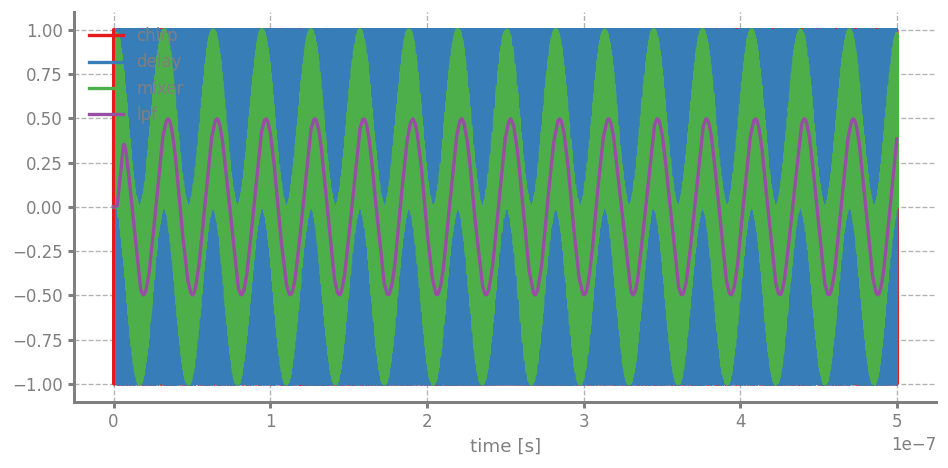

(<Figure size 960x480 with 1 Axes>, <Axes: xlabel='time [s]'>)

In [5]:
#plot the recording of the scope
Sco.plot()

It only really gets interesting in the frequency domain. So lets look at the spectrum block (and scale it logarithmically):

In [9]:
#read the frequency spectra
freq, data = Spc.read()

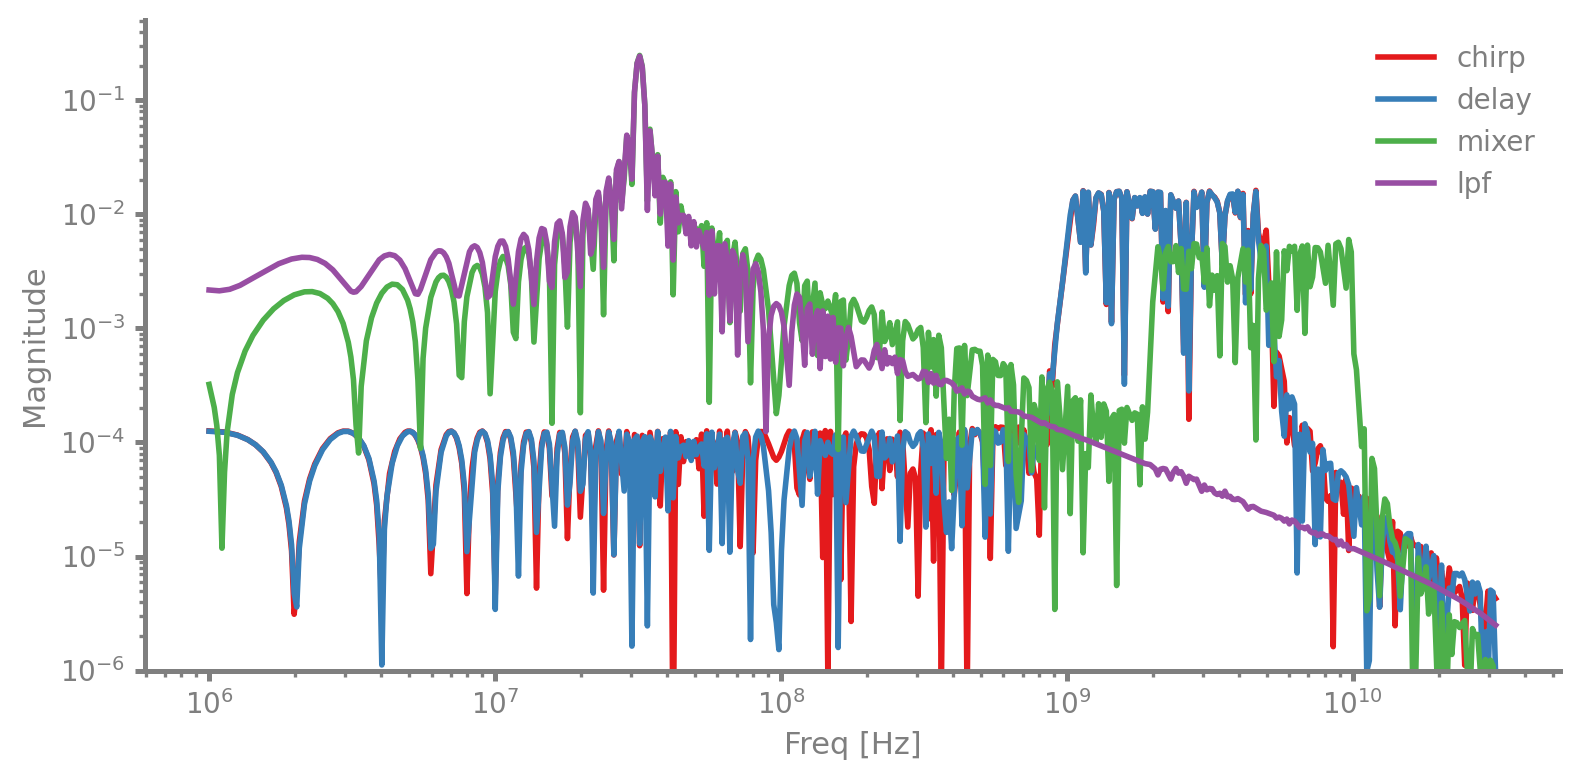

In [10]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=200)

for i, d in enumerate(data):
    ax.loglog(freq, abs(d), label=Spc.labels[i])

ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("Magnitude")
ax.set_ylim(1e-6, None)
ax.legend();

In the spectrum the trace of interest is the output of the low pass filter (purple trace) which is intended to select the signal component that represents the delay, or radar distance. The position of the peak corresponds directly to the target distance, represented by the delay block.

Isolating the spectrum of the lowpass filter and adding the expected target distance (as a frequency) to the plot shows that the FMCW radar system can indeed correctly resolve the range:

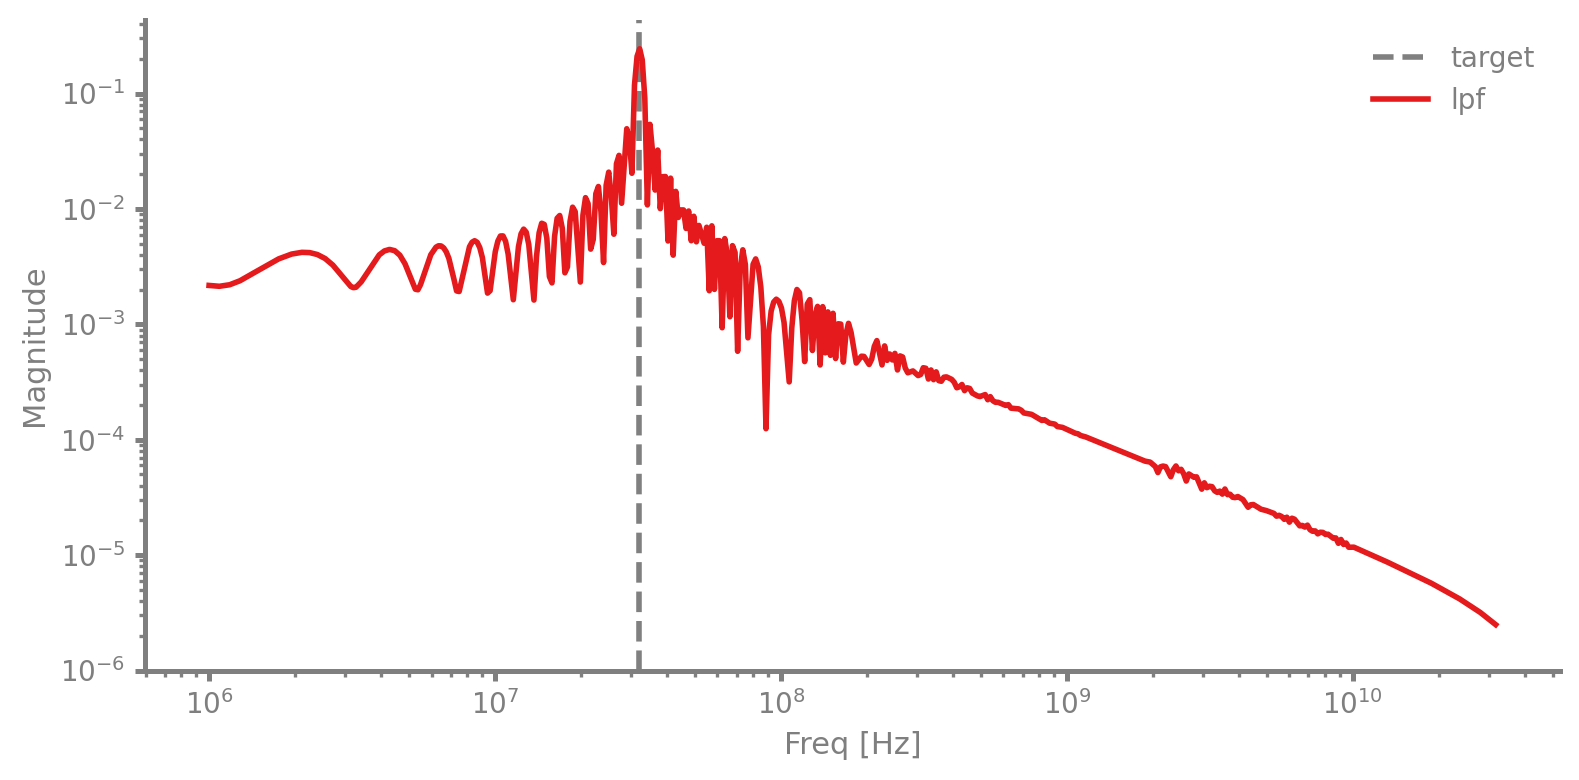

In [16]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=200)

ax.axvline(f_trg, ls="--", c="grey", label="target")

data_lpf = data[3]
ax.loglog(freq, abs(data_lpf), label=Spc.labels[3])

ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("Magnitude")
ax.set_ylim(1e-6, None)
ax.legend();
